## What is SciPy?

SciPy is a third-party library for scientific computing based on NumPy. It offers additional functionality compared to NumPy, including scipy.stats for statistical analysis.

This module contains a large number of probability distributions, summary and frequency statistics, correlation functions and statistical tests, masked statistics, kernel density estimation, quasi-Monte Carlo functionality, and more.
[Source: Python Statistics Fundamentals: How to Describe Your Data](https://realpython.com/python-statistics/) and [docs.scipy.org](https://docs.scipy.org/doc/scipy/reference/stats.html)

<br>

# ANOVA

---

### Case study with COVID-19 data

[Source: Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/)

<br>

![title](https://raw.githubusercontent.com/thenriq/machine_Learning_Assessment/main/images/logo_corona.jpg)

<br>

### What is the ANOVA Test?

An Analysis of Variance Test, or ANOVA, can be thought of as a generalization of the t-tests for more than 2 groups. The independent t-test is used to compare the means of a condition between two groups. ANOVA is used when we want to compare the means of a condition between more than two groups.

---

To perform any tests, we first need to define the null and alternate hypothesis:

- **Null Hypothesis – There is no significant difference among the groups**
- **Alternate Hypothesis – There is a significant difference among the groups**

<br>

### Importing Libraries

---

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import os
import random

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


os.getcwd()
#os.chdir('D:\Qurantine\Blog\ANOVA Test')

'D:\\Users\\Thiago\\Documents\\OneDrive - GMIT\\GMIT\\4th Semester\\Machine Learning and Statistics\\repo\\machine_Learning_Assessment'

<br>

#### Importing the data

[Source: MiPasa](https://app.mipasa.com/datasets/view/e0b68c6d-a336-413e-ba58-94ab1b86f5d1/covid-19-india-testing-samples), [Covid-19 i India - Kaggle](https://www.kaggle.com/sudalairajkumar/covid19-in-india/version/91?select=population_india_census2011.csv)

In [2]:
StatewiseTestingDetails=pd.read_csv('./datasets/statewise_testing_details.csv')
population_india_census2011=pd.read_csv('./datasets/population_india_census2011.csv')

**statewise_testing_details.csv** contains information about total positive & negative cases in a day in each state. 

Whereas **population_india_census2011.csv** contains information about the density of each state and other related information about population.

<br>

In [3]:
population_india_census2011.head() #take glimpse of data
StatewiseTestingDetails.head() #take glimpse of data
StatewiseTestingDetails['Positive'].sort_values().head() #sort values

2780    0.0
2790    0.0
2789    0.0
2788    0.0
2787    0.0
Name: Positive, dtype: float64

In [4]:
##We see that there're many entries with 0. That means no case has been detected. So we can add 1 in all entries.
#So while perfroming any sort of Data transformation that involves log in it , won't give error.
StatewiseTestingDetails['Positive']=StatewiseTestingDetails['Positive']+1

From the above code snippet, we can see that there’re a few states that have 0 or no corona cases in a day. So let’s check out such states:

<br>

In [5]:
StatewiseTestingDetails['state'][StatewiseTestingDetails['Positive']==1].unique()

array(['Dadra and Nagar Haveli and Daman and Diu', 'Nagaland', 'Sikkim'],
      dtype=object)

We see that Nagaland & Sikkim have no corona case also in a day. On the other hand, Arunachal Pradesh & Mizoram states have only 1 corona case in a day.

**Impute Missing values**: We’ve noticed that there are many missing values in the ‘Positive’ column. So let’s impute these missing values by the median of Positive with respect to each state:

In [6]:
stateMedianData=StatewiseTestingDetails.groupby('state')[['Positive']].median().reset_index().rename(columns={'Positive':'Median'})
stateMedianData.head()

for index,row in StatewiseTestingDetails.iterrows():

    if pd.isnull(row['Positive']):

        StatewiseTestingDetails['Positive'][index]=int(stateMedianData['Median'][stateMedianData['state']==row['state']])


data=pd.merge(StatewiseTestingDetails,population_india_census2011,on='state')


C:\Users\Thiago\AppData\Local\Temp/ipykernel_18252/3640431126.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StatewiseTestingDetails['Positive'][index]=int(stateMedianData['Median'][stateMedianData['state']==row['state']])


Now we can write a function to create a density group bucket as per the density of each state, where Dense1 < Dense2 < Dense3 < Dense4:

In [7]:
def densityCheck(data):
    data['density_Group']=0
    for index,row in data.iterrows():
        status=None
        i=row['density'].split('/')[0]
        try:
            if (',' in i):
                i=int(i.split(',')[0]+i.split(',')[1])
            elif ('.' in i):
                i=round(float(i))
            else:
                i=int(i)
        except ValueError as err:
            pass
        try:
            if (0<i<=300):
                status='Dense1'
            elif (300<i<=600):
                status='Dense2'
            elif (600<i<=900):
                status='Dense3'
            else:
                status='Dense4'
        except ValueError as err:
            pass
        data['density_Group'].iloc[index]=status
    return data

Now, map each state with its density group. And we can export this data so we can use that in the two- way ANOVA test later:

In [8]:
data=densityCheck(data)
#We'll export this data so we can use it for Two - way ANOVA test.
stateDensity=data[['state','density']].drop_duplicates().sort_values(by='state')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
data.head()

,Date,state,TotalSamples,Negative,Positive,Sno,Population,rural_population,urban_population,area,density,gender_ratio,density_Group
0,17/04/2020,Andaman and Nicobar Islands,1403,1210,13.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
1,24/04/2020,Andaman and Nicobar Islands,2679,NaN,28.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
2,27/04/2020,Andaman and Nicobar Islands,2848,NaN,34.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
3,01/05/2020,Andaman and Nicobar Islands,3754,NaN,34.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1
4,16/05/2020,Andaman and Nicobar Islands,6677,NaN,34.0,34,380581,237093,143488,"8,249 km2 (3,185 sq mi)",46/km2 (120/sq mi),876,Dense1


In [10]:
data.describe()

,TotalSamples,Positive,Sno,Population,rural_population,urban_population,gender_ratio
count,4.160000e+03,4160.000000,4160.000000,4.160000e+03,4.160000e+03,4.160000e+03,4160.000000
mean,2.843928e+05,17699.353125,17.490865,3.689229e+07,2.544158e+07,1.145071e+07,937.533173
std,5.027049e+05,52184.364040,10.123328,4.396405e+07,3.292089e+07,1.338791e+07,64.395914
min,5.800000e+01,1.000000,1.000000,2.740000e+05,2.899100e+04,1.434880e+05,711.000000
25%,1.414125e+04,214.000000,8.000000,1.978502e+06,1.066358e+06,7.765150e+05,895.000000
50%,6.815950e+04,1717.500000,18.000000,2.535146e+07,1.650936e+07,7.003656e+06,948.000000
75%,3.317832e+05,10472.000000,26.000000,6.109530e+07,3.722959e+07,1.704808e+07,976.000000
max,3.786633e+06,607632.000000,35.000000,1.998123e+08,1.553173e+08,5.081826e+07,1084.000000


Let’s subset and rearrange the dataset that we can use for our ANOVA test:

In [11]:
df=pd.DataFrame({'Dense1':data[data['density_Group']=='Dense1']['Positive'],
                 'Dense2':data[data['density_Group']=='Dense2']['Positive'],
                 'Dense3':data[data['density_Group']=='Dense3']['Positive'],
                 'Dense4':data[data['density_Group']=='Dense4']['Positive']})

In [12]:
df.describe()

,Dense1,Dense2,Dense3,Dense4
count,1750.000000,1393.000000,269.000000,748.000000
mean,4202.157714,36009.932520,14379.133829,16371.270053
std,8824.218215,82458.981931,22485.014239,32707.491930
min,1.000000,3.000000,266.000000,1.000000
25%,59.250000,965.000000,975.000000,199.250000
50%,650.000000,4958.000000,4754.000000,1263.000000
75%,3252.500000,26738.000000,18100.000000,11710.250000
max,61297.000000,607632.000000,126723.000000,151929.000000


In [13]:
df.head()

,Dense1,Dense2,Dense3,Dense4
0,13.0,NaN,NaN,NaN
1,28.0,NaN,NaN,NaN
2,34.0,NaN,NaN,NaN
3,34.0,NaN,NaN,NaN
4,34.0,NaN,NaN,NaN


<br>

One of our ANOVA test’s assumptions is that samples should be randomly selected and should be close to Gaussian Distribution. So let’s select 10 random samples from each factor or level:

In [14]:
np.random.seed(1234)
dataNew=pd.DataFrame({'Dense1':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10),
'Dense2':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10),
'Dense3':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10),
'Dense4':random.sample(list(data['Positive'][data['density_Group']=='Dense1']), 10)})

Let’s plot a density distribution of the number of Corona cases to check their distribution across different density groups:

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.03 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.03 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.03 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is d

<AxesSubplot:title={'center':'density Group -Dense4 & Corona Cases'}, xlabel='density Group -Dense4', ylabel='Corona Cases'>

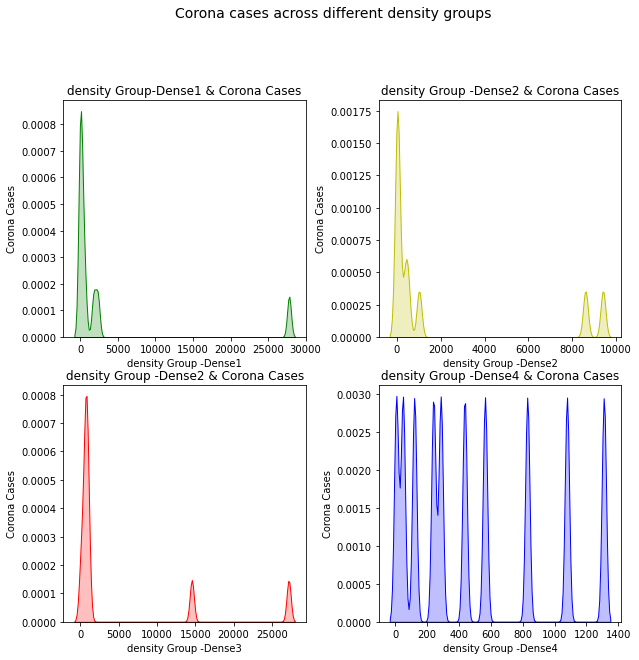

In [15]:
#Plot number of Corona cases across different density groups to check their distribution.
fig = plt.figure(figsize=(10,10))
title = fig.suptitle("Corona cases across different density groups", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.set_title("density Group-Dense1 & Corona Cases")
ax1.set_xlabel("density Group -Dense1")
ax1.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense1'], ax=ax1, shade=True, bw=0.03, color='g')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense2")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense2'], ax=ax2, shade=True,bw=0.03, color='y')

ax2 = fig.add_subplot(2,2,3)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense3")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense3'], ax=ax2, shade=True, bw=0.03,color='r')

ax2 = fig.add_subplot(2,2,4)
ax2.set_title("density Group -Dense4 & Corona Cases")
ax2.set_xlabel("density Group -Dense4")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense4'], ax=ax2, shade=True, bw=0.03,color='b')

We can clearly see that the data doesn’t follow the Gaussian distribution.

There are different data transformation methods available to bring the data to close to Gaussian Distribution. We’ll go ahead with Box Cox transformation:

In [16]:
dataNew.describe()

,Dense1,Dense2,Dense3,Dense4
count,10.000000,10.000000,10.000000,10.000000
mean,3299.700000,1997.300000,4688.700000,491.000000
std,8644.217271,3710.519462,9031.462218,449.141156
min,1.000000,1.000000,34.000000,5.000000
25%,9.500000,10.000000,615.500000,149.000000
50%,224.000000,215.500000,799.000000,360.000000
75%,1491.750000,878.000000,1031.750000,762.500000
max,27790.000000,9403.000000,27175.000000,1310.000000


In [17]:
dataNew['Dense1'],fitted_lambda = stats.boxcox(dataNew['Dense1'])
dataNew['Dense2'],fitted_lambda = stats.boxcox(dataNew['Dense2'])
dataNew['Dense3'],fitted_lambda = stats.boxcox(dataNew['Dense3'])
dataNew['Dense4'],fitted_lambda = stats.boxcox(dataNew['Dense4'])

<br>

Now let’s plot their distribution once again to check:

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated

<AxesSubplot:title={'center':'density Group -Dense4 & Corona Cases'}, xlabel='density Group -Dense4', ylabel='Corona Cases'>

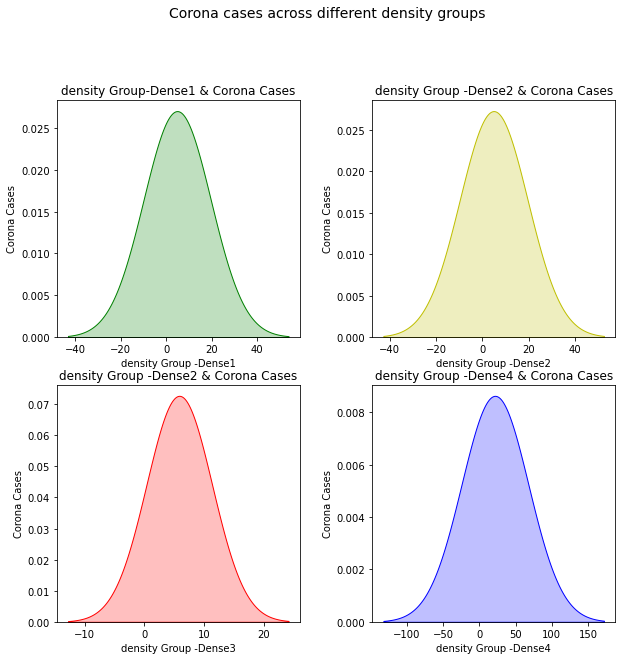

In [18]:
#Plot different density groups
fig = plt.figure(figsize=(10,10))
title = fig.suptitle("Corona cases across different density groups", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.set_title("density Group-Dense1 & Corona Cases")
ax1.set_xlabel("density Group -Dense1")
ax1.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense1'], ax=ax1, shade=True,bw=4, color='g')

ax2 = fig.add_subplot(2,2,2)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense2")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense2'], ax=ax2, shade=True,bw=4, color='y')

ax2 = fig.add_subplot(2,2,3)
ax2.set_title("density Group -Dense2 & Corona Cases")
ax2.set_xlabel("density Group -Dense3")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense3'], ax=ax2, shade=True,bw=4, color='r')

ax2 = fig.add_subplot(2,2,4)
ax2.set_title("density Group -Dense4 & Corona Cases")
ax2.set_xlabel("density Group -Dense4")
ax2.set_ylabel("Corona Cases") 
sns.kdeplot(dataNew['Dense4'], ax=ax2, shade=True,bw=4, color='b')

## Approach 1: One-Way ANOVA Test using statsmodels module

There are a couple of methods in Python to perform an ANOVA test. One is with the stats.f_oneway() method:

---

In [19]:
F, p = stats.f_oneway(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])
# Seeing if the overall model is significant
print('F-Statistic=%.3f, p=%.3f' % (F, p))

F-Statistic=17.232, p=0.000


We see that p-value <0.05. Hence, we can reject the Null Hypothesis – there are no differences among different density groups.

<br>

### Approach 2: One-Way ANOVA Test using OLS Model

As we know in regression, we can regress against each input variable and check its influence over the Target variable. So, we’ll follow the same approach, the approach we follow in Linear Regression.

---

In [20]:
#Rearrange DataFrame
newDf=dataNew.stack().to_frame().reset_index().rename(columns={'level_1':'density_Group',
                                                               0:'Count'})
del newDf['level_0']


In [21]:
model = ols('Count ~ C(density_Group)', newDf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     17.23
Date:                Sat, 18 Dec 2021   Prob (F-statistic):           4.18e-07
Time:                        14:50:55   Log-Likelihood:                -127.60
No. Observations:                  40   AIC:                             263.2
Df Residuals:                      36   BIC:                             269.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.8520      1.959      2.477      0.018       0.879       8.825
C(density_Group)[T.Dense2]     0.0431      2.770      0.016      0.988      -5.575       5.661
C(density_Group)[T.Dense3]     0.9884      2.770      0.357      0.723      -4.630       6.607
C(density_Group)[T.Dense4]    16.5812      2.770      5.986      0.000      10.963      22.199
==============================================================================
Omnibus:                        7.944   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               12.179
Skew:                          -0.347   Prob(JB):                      0.00227
Kurtosis:                       5.612   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

Overall model F( 3, 36) =  17.232, p =  0.0000


,sum_sq,df,F,PR(>F)
C(density_Group),1983.624220,3.0,17.232472,4.184614e-07
Residual,1381.316088,36.0,NaN,NaN


From the above output results, we see that the p-value is less than 0.05. Hence, we can reject the Null Hypothesis that there’s no difference among different density groups.

The F-statistic= 5.817 and the p-value= 0.002 which is indicating that there is an overall significant effect of density_Group on corona positive cases. However, we don’t know where the difference between desnity_groups is yet. So, based on the p-value we can reject the H0; that is there’s no significant difference as per density of an area and number of corona cases.

<br>
## Post Hoc Tests

When we conduct an ANOVA, we are attempting to determine if there is a statistically significant difference among the groups. So what if we find statistical significance?

If we find that there is a difference, we will then need to examine where the group differences lay. So, we’ll use the Tukey HSD test to identify where the difference lies:

In [23]:
mc = statsmodels.stats.multicomp.MultiComparison(newDf['Count'],newDf['density_Group'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
Dense1 Dense2   0.0431   0.9 -7.4177   7.504  False
Dense1 Dense3   0.9884   0.9 -6.4724  8.4492  False
Dense1 Dense4  16.5812 0.001  9.1203  24.042   True
Dense2 Dense3   0.9453   0.9 -6.5156  8.4061  False
Dense2 Dense4   16.538 0.001  9.0772 23.9989   True
Dense3 Dense4  15.5928 0.001  8.1319 23.0536   True
---------------------------------------------------


Tuckey HSD test clearly says that there’s a significant difference between Group1 – Group3 , Group1 – Group4, Group2 – Group3, and Group3 – Group4.

This suggests that except for the mentioned groups, all other pairwise comparisons for the number of Corona cases reject the null hypothesis and indicate no statistically significant differences.

<br>

## Assumption Checks/Model Diagnostics
## Normal Distribution Assumption check

When working with linear regression and ANOVA models, the assumptions pertain to the residuals and not the variables themselves.

---

<br>

#### Method 1: Shapiro Wilk test:

In [24]:
### Normality Assumption check
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.923241138458252 0.009752215817570686


From the above snippet of code, we see that the p-value is >0.05 for all density groups. Hence, we can conclude that they follow the Gaussian Distribution.

<br>

#### Method 2: Q-Q plot test:

We can use the Normal Q-Q plot to test this assumption:

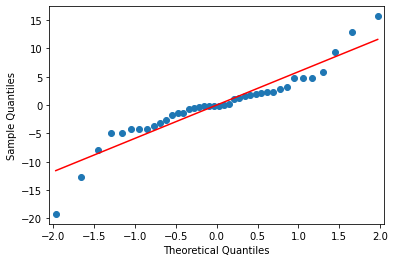

In [25]:
res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

From the above figure, we see that all data points lie to close to the 45-degree line and hence we can conclude that it follows Normal Distribution.

<br>

#### Homogeneity of Variance Assumption check

The homogeneity of variance assumption should be checked for each level of the categorical variable. We can use the Levene’s test to test for equal variances between groups.

In [26]:
w, pvalue = stats.bartlett(newDf['Count'][newDf['density_Group']=='Dense1'], newDf['Count'][newDf['density_Group']=='Dense2']
                           , newDf['Count'][newDf['density_Group']=='Dense3'], newDf['Count'][newDf['density_Group']=='Dense4'])
print(w, pvalue)

# Levene variance test, Method 2
stats.levene(dataNew['Dense1'],dataNew['Dense2'],dataNew['Dense3'],dataNew['Dense4'])

35.085223518234606 1.1687739627046671e-07


LeveneResult(statistic=11.116531023149799, pvalue=2.6092541734314563e-05)

We see that p-value >0.05 for all density groups. Hence, we can conclude that groups have equal variances.